## Choosing Trasit Width for Cutouts

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import random
import math
from analysis_tools_cython import *

In [34]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/2_min_cadence_targets/tesslc_349677777.pkl",sector=6,return_type='pandas')
data = data[['time','corrected flux','quality','flux error']]

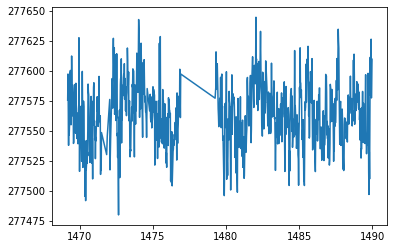

In [35]:
plt.plot(data['time'],data['corrected flux'])

#### Making the lightcurve

In [36]:
time_range = data["time"][
data["time"].between(
    data["time"].min() + 1, data["time"].max() - 1, inclusive=False
    )
].reset_index(
    drop=True
)
injected_time_index, injected_time = random.choice(list(enumerate(time_range)))
depth = 10 ** np.random.uniform(-4, -2, 1)[0]
#time = np.linspace(1469,1490,1000)
comet = 1-comet_curve(data['time'],depth, injected_time,  3.02715600e-01, 3.40346173e-01)
data['corrected flux'] = (np.ones(len(data['corrected flux'])) * comet) - 1
#data['corrected flux'] = data['corrected flux'] * comet
#flux = (np.ones(1000) * comet) -1
#quality = np.zeros(len(flux))
#flux_error = np.zeros(len(flux))
#data = Table([time,flux,quality,flux_error],names=['time','corrected flux','quality','flux_error'])

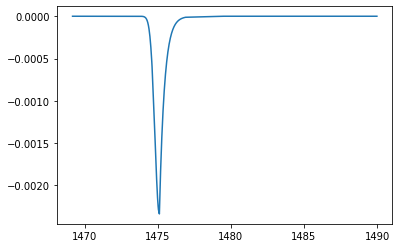

In [37]:
plt.plot(data['time'],data['corrected flux'])

In [38]:
data = Table.from_pandas(data)

So it is normalised here.

In [39]:
flat_flux, trend_flux = smoothing(data,method=None)

In [40]:
t, flux, quality, real, flux_error = clean_data(data)
#flux = normalise_flux(flux)
#flux *= real

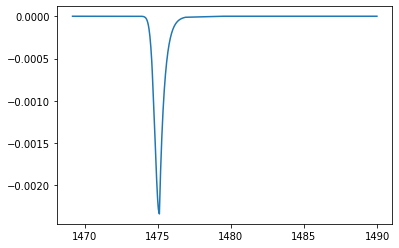

In [41]:
plt.plot(t,flux)

In [42]:
df = pd.DataFrame([t,flux,quality,flux_error]).T
df.columns = ['time','flux','quality','flux_error']
df['time'].diff().round(6).unique()

array([     nan, 0.020834])

In [43]:
print(len(data))

823


In [44]:
timestep = calculate_timestep(data)
factor = ((1/48)/timestep) 
T1 = test_statistic_array(flux,60 * factor)

m, n = np.unravel_index(
T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
#Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n-math.floor((m-1)/2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean() 
Ts = nonzero(T1[m]).std() # only the box width selected. Not RMS of all T-statistic
asym, width1, width2, depth, info = calc_shape(m,n,t,quality,flux,flux_error)

[1.583752895725806e-06, 5.173504280317003e-09]
306.12768636363484


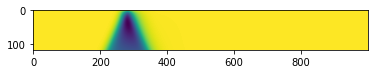

In [45]:
plt.imshow(T1)

In [46]:
def calc_shape(m,n,time,quality,flux,flux_error,n_m_bg_start=2,n_m_bg_scale_factor=3):
    """Fit both symmetric and comet-like transit profiles and compare fit.
    Returns:
    (1) Asymmetry: ratio of (errors squared)
    Possible errors and return values:
    -1 : Divide by zero as comet profile is exact fit
    -2 : Too close to end of light curve to fit profile
    -3 : Unable to fit model (e.g. timeout)
    -4 : Too much empty space in overall light curve or near dip
    (2,3) Widths of comet curve fit segments.
    info: t, x, q, fit1 and fit2 are the transit shape elements 

    """
    ## how many transit widths to take the general linear trend from. start is 1/4 length of cutout from beginning, end is 1 from end.
    #first_index = n - (n_m_bg_start*n)
    #last_index = n - (n_m_bg_end*m)
    
    
    ## the transit widths of the cutout from the T-statistic minimum value. 
    ## this project requires the cutout to have more transit widths after the midtransit, to cover more of the tail.
    ## default is set to 1 transit width before and 2 transit widths after 

    n_m_bg_end = n_m_bg_scale_factor*n_m_bg_start
    
    if (n-(m*n_m_bg_start))>= 0 and (n+(m*n_m_bg_end))< len(time):
        t = time[n-(m*n_m_bg_start):n+(m*n_m_bg_end)]
        if (t[-1]-t[0]) / np.median(np.diff(t)) / len(t) > 1.5:
            return -4,-4,-4, 0, 0
        t0 = time[n]
        diffs = np.diff(t)

        x = flux[n-(m*n_m_bg_start):n+(m*n_m_bg_end)]
        q = quality[n-(m*n_m_bg_start):n+(m*n_m_bg_end)]
        fe = flux_error[n-(m*n_m_bg_start):n+(m*n_m_bg_end)]
        
        bg_before = np.mean(x[:int(m/4)])
        bg_time_before = np.mean(t[:int(m/4)])
        bg_after = np.mean(x[-int(round(m/4)):])
        bg_time_after = np.mean(t[-int(round(m/4)):])
        
        
        grad = (bg_after-bg_before)/(bg_time_after-bg_time_before)
        background_level = bg_before + grad * (t - bg_time_before)
        x -= background_level
        try:
            params1, pcov1 = single_gaussian_curve_fit(t,-x)
            params2, pcov2 = comet_curve_fit(t,-x)
        except:
            return -3,-3,-3, 0, 0

        fit1 = -gauss(t,*params1)
        fit2 = -comet_curve(t,*params2)
        depth = fit2.min()

        scores = [score_fit(x,fit) for fit in [fit1,fit2]]
        print(scores)
        if scores[1] > 0:
            print(scores[0]/scores[1])
            return scores[0]/scores[1], params2[2], params2[3], depth, [t,x,q,fe,fit1,fit2,background_level]
        else:

            return -1,-1,-1, 0, 0 
    else:     

        return -2,-2,-2, 0, 0

In [49]:
asym, width1, width2, depth, info = calc_shape(m,n,t,quality,flux,flux_error)


[1.583752895725806e-06, 5.173504280314599e-09]
306.1276863637771


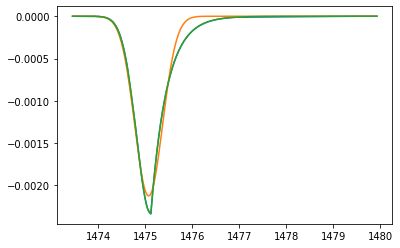

In [50]:
plt.plot(info[0],info[1])
plt.plot(info[0],info[4])
plt.plot(info[0],info[5])

In [51]:
n_m_bg_start = 1
n_m_bg_end = 2*n_m_bg_start
time = t[n-m*(n_m_bg_start):n+m*(n_m_bg_end)]
f = flux[n-m*(n_m_bg_start):n+m*(n_m_bg_end)]

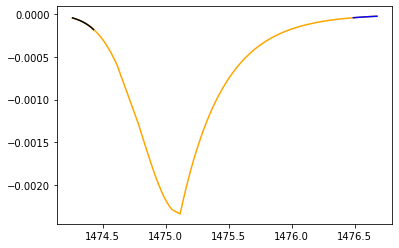

In [52]:
plt.plot(time[:int(m/4)],f[:int(m/4)],color='black',zorder=3)
plt.plot(time[-int(round(m/4)):],f[-int(round(m/4)):],zorder=3,color='blue')

plt.plot(time,f,color='orange')

---

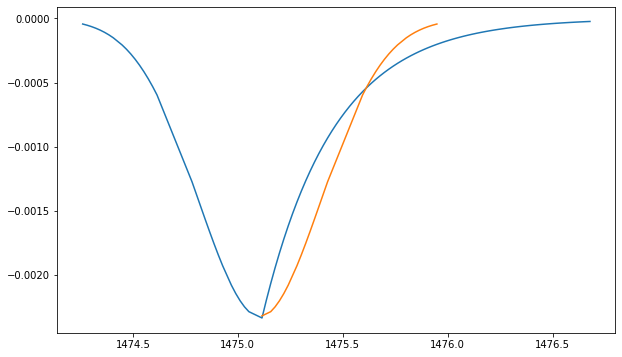

In [83]:
plt.figure(figsize=(10,6))
plt.plot(time,f)
plt.plot(time[41:41*2],flipped)

In [82]:
flipped - f[41:41*2] 

array([ 1.64318534e-05, -1.05931169e-04, -2.20052925e-04, -3.05233492e-04,
       -3.73280984e-04, -4.25279730e-04, -4.62401825e-04, -4.82578713e-04,
       -4.97047562e-04, -4.97204786e-04, -4.87714357e-04, -4.69924468e-04,
       -4.45161351e-04, -4.14711369e-04, -3.79804620e-04, -3.41600445e-04,
       -3.12344359e-04, -2.79798045e-04, -2.44156867e-04, -2.05604591e-04,
       -1.64314070e-04, -1.20447894e-04, -7.41589982e-05, -2.55912386e-05,
        5.91440738e-06,  3.45024073e-05,  6.00748890e-05,  8.26040559e-05,
        1.02122843e-04,  1.18715473e-04,  1.32508157e-04,  1.43660175e-04,
        1.50609854e-04,  1.58795116e-04,  1.63190110e-04,  1.65755643e-04,
        1.66705775e-04,  1.66249181e-04,  1.64585706e-04,  1.61903727e-04,
        1.58378241e-04])

In [39]:
asym, width1, width2, depth, info = calc_shape(m,n,t,quality,flux,flux_error,n_m_bg_scale_factor=2)

[1.995297086651663e-06, 8.062844764684745e-12]
247468.12631083548


NameError: name 'f' is not defined

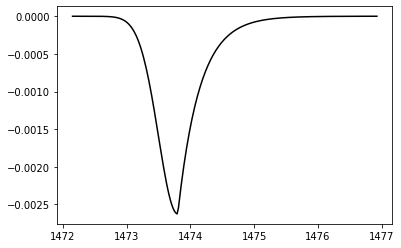

In [40]:
plt.plot(info[0],info[1],color='black',zorder=3)
plt.plot(time[-int(round(m/4)):],f[-int(round(m/4)):],zorder=3,color='blue')

plt.plot(time,f,color='orange')